In [1]:
import warnings
import numpy as np
import pandas as pd
import gensim as gs
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
warnings.filterwarnings('ignore')

In [4]:
read_file = pd.read_csv('dataset/train_dataset_random_1_1', delimiter=',', header=None)
train_dataset = read_file.iloc[:,:].values

In [9]:
read_file = pd.read_csv('dataset/validation_dataset_random_1_5', delimiter=',', header=None)
validation_dataset = read_file.iloc[:,:].values

In [2]:
embedding_model = gs.models.FastText.load_fasttext_format('pre_trained_models/cc.en.300.bin')

In [6]:
MAX_PAD = 9

def sequence_padding(X_DIM, value):
    
    value_padding = np.pad(value, ((0,MAX_PAD - X_DIM),(0,0)), 'constant')
    
    return value_padding

In [7]:
def create_embedding(value):

    value = tknzr.tokenize(str(value))
    
    if len(value) < MAX_PAD:
        
        embedding = embedding_model.wv[value]
        
        padding_embedding = sequence_padding(embedding.shape[0],embedding)
        
        return padding_embedding
        
    else:
        
        embedding = embedding_model.wv[value[0:MAX_PAD]]
        
        return embedding

In [8]:
train_article_title = []
train_table_title = []
train_label = []

for articleID, articleTitle, meta_description, keywords, tableID, tableTitle, match in tqdm(train_dataset):
    
    train_article_title.append(create_embedding(articleTitle))
    train_table_title.append(create_embedding(tableTitle))
    train_label.append(match)

100%|██████████| 133294/133294 [00:23<00:00, 5649.28it/s]


In [10]:
train_article_title = np.array(train_article_title)
train_table_title = np.array(train_table_title)
train_label = np.array(train_label)

In [11]:
train_article_title.shape

(133294, 9, 300)

In [12]:
validation_article_title = []
validation_table_title = []
validation_label = []

for articleID, articleTitle, meta_description, keywords, tableID, tableTitle, match in tqdm(validation_dataset):
    
    validation_article_title.append(create_embedding(articleTitle))
    validation_table_title.append(create_embedding(tableTitle))  
    validation_label.append(match)

100%|██████████| 3179/3179 [00:00<00:00, 5540.00it/s]


In [13]:
validation_article_title = np.array(validation_article_title)
validation_table_title = np.array(validation_table_title)
validation_label = np.array(validation_label)

In [14]:
validation_article_title.shape

(3179, 9, 300)

In [15]:
def coattention_method(query, document):
    
    transpose_document = tf.transpose(document,perm=[0, 2, 1])
    
    affinity = tf.matmul(query,transpose_document)

    #transpose_affinity = tf.transpose(affinity, perm=[0, 2, 1])
    
    #row_normalized = tf.nn.softmax(affinity, axis=1)
    
    #column_normalized = tf.nn.softmax(transpose_affinity, axis=1)
    
    #context_vector = tf.matmul(row_normalized,document)
    
    #concatenate_context_query = tf.concat([context_vector,query],axis=-1)
     
    #context_document = tf.matmul(column_normalized,concatenate_context_query)
    
    #co_attention = tf.concat([document,context_document],axis=-1)
    
    return affinity

In [51]:
def attention_model():
    
    article_title = tf.keras.Input(shape=(9,300), dtype='float32')
    table_title = tf.keras.Input(shape=(9,300), dtype='float32')
    
    encodding_article_title = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(article_title)
    encodding_table_title = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(table_title)
    
    #attention_title_title = coattention_method(encodding_article_title,encodding_table_title)
    
    
    #flatten1 = tf.keras.layers.Flatten()(attention_title_title)
    
    flatten1 = tf.keras.layers.Flatten()(encodding_article_title)
    flatten2 = tf.keras.layers.Flatten()(encodding_table_title)
    L1_distance = tf.keras.layers.dot([flatten1,flatten2], axes=1, normalize=True)
    
    prediction = tf.keras.layers.Dense(1,activation='sigmoid')(L1_distance)
    
    model = tf.keras.Model(inputs=[article_title,table_title],outputs=prediction)
    
    return model

In [52]:
model = attention_model()

In [53]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 9, 300)]     0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 9, 300)]     0                                            
__________________________________________________________________________________________________
bidirectional_8 (Bidirectional) (None, 9, 128)       186880      input_11[0][0]                   
__________________________________________________________________________________________________
bidirectional_9 (Bidirectional) (None, 9, 128)       186880      input_12[0][0]                   
____________________________________________________________________________________________

In [ ]:
tf.keras.utils.plot_model(model, to_file='test.png')

In [43]:
model.compile(loss="binary_crossentropy",optimizer="adam", metrics=['accuracy'])

In [ ]:
# checkpoint = tf.keras.callbacks.ModelCheckpoint('attention.h5', monitor='val_acc',verbose=1, save_the_best_only=True, mode='max')
# callbacks_list = [checkpoint]

In [44]:
history = model.fit([train_article_title, train_table_title], train_label, 
          epochs=10, 
          batch_size=32, 
          validation_data=([validation_article_title, validation_table_title], validation_label))
          #callbacks=callbacks_list)

Train on 133294 samples, validate on 3179 samples
Epoch 1/10
133294/133294 [==============================] - 42s 316us/sample - loss: 0.4117 - accuracy: 0.8396 - val_loss: 0.3176 - val_accuracy: 0.8836
Epoch 2/10
133294/133294 [==============================] - 37s 280us/sample - loss: 0.2485 - accuracy: 0.9166 - val_loss: 0.2113 - val_accuracy: 0.9308
Epoch 3/10
133294/133294 [==============================] - 37s 280us/sample - loss: 0.1699 - accuracy: 0.9463 - val_loss: 0.1641 - val_accuracy: 0.9437
Epoch 4/10
133294/133294 [==============================] - 37s 280us/sample - loss: 0.1198 - accuracy: 0.9646 - val_loss: 0.1355 - val_accuracy: 0.9556
Epoch 5/10
133294/133294 [==============================] - 37s 280us/sample - loss: 0.0850 - accuracy: 0.9770 - val_loss: 0.1099 - val_accuracy: 0.9629
Epoch 6/10
133294/133294 [==============================] - 37s 280us/sample - loss: 0.0598 - accuracy: 0.9855 - val_loss: 0.1208 - val_accuracy: 0.9550
Epoch 7/10
133294/133294 [======

In [45]:
model.save('affinity_model_ramdom_1_1.h5')

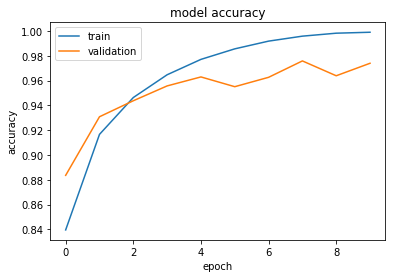

In [46]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

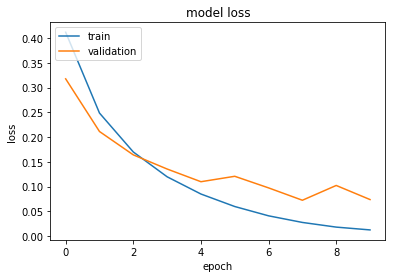

In [47]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [48]:
y_prob = model.predict([validation_article_title,validation_table_title])
y_prob = (y_prob > 0.5).astype(np.int)
accuracy_score(validation_label, y_prob)

0.9738911607423718

In [49]:
classes=[0,1]
con_mat = tf.math.confusion_matrix(labels=validation_label, predictions=y_prob).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)

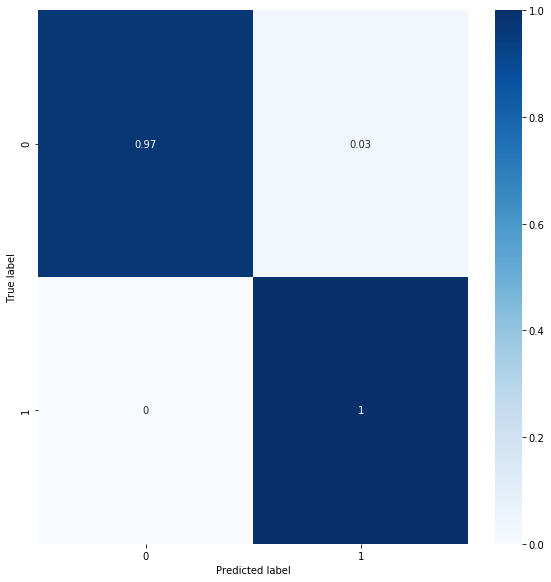

In [50]:
import seaborn as sns;
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()